In [54]:
#!pip install yfinance
#!pip install hmmlearn
#pip install arch
#pip install scipy
#pip install --upgrade --user hmmlearn
#pip install --user git+https://github.com/hmmlearn/hmmlearn
from sklearn.mixture import GaussianMixture
import yfinance as yf
import numpy as np
from numpy import random
import pandas as pd
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score 
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2, t, norm
import datetime as dt
from datetime import datetime
from itertools import product
from arch import arch_model

# Data collection

In [55]:
ticker = "^GSPC"  #S&P 500 index symbol
daily = yf.download(ticker, start="1950-01-01", end="2024-11-30", interval="1d")
#daily.loc[(daily['Open'] == 0) & (daily.index >= '1961-12-29') & (daily.index <= '1982-04-20'), 'Open'] = np.nan
#Before 29th Dec 1961, same values in the row
#Between 29th Dec 1961 and 20th April 1982, "Open" set to 0

daily = daily[daily.columns[0:4]]

[*********************100%%**********************]  1 of 1 completed


c:\Users\graci\anaconda3\Lib\site-packages\yfinance\utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [56]:
# Resample the data to monthly frequency
monthly = daily.resample('MS').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})
monthly = monthly.dropna()
monthly_with_dates = monthly

# Reset the index to have 'Date' as a column
monthly = monthly.reset_index()

#calculate log returns
log_returns = np.log(monthly_with_dates['Close'] / monthly_with_dates['Close'].shift(1)).dropna()


<Axes: >

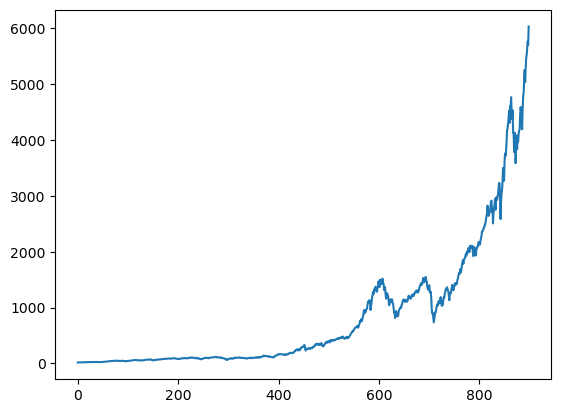

In [57]:
monthly['Close'].plot()

# Test for stationarity 

In [58]:
True_price = monthly_with_dates['Close']
print(True_price.shape)

(899,)


In [59]:
True_price

Date
1950-01-01      17.049999
1950-02-01      17.219999
1950-03-01      17.290001
1950-04-01      17.959999
1950-05-01      18.780001
                 ...     
2024-07-01    5522.299805
2024-08-01    5648.399902
2024-09-01    5762.479980
2024-10-01    5705.450195
2024-11-01    6032.379883
Freq: MS, Name: Close, Length: 899, dtype: float64

In [60]:
sm.tsa.stattools.adfuller(True_price, regression='n', autolag='BIC', store=False, regresults=True)

(5.530603168749355,
 1.0,
 {'1%': -2.5682738268565344,
  '5%': -1.941308107020567,
  '10%': -1.616522983799078},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2a4f8e12c90>)

In [61]:
sm.tsa.stattools.adfuller(True_price, regression='c', autolag='BIC', store=False, regresults=True)

(4.977697371218509,
 1.0,
 {'1%': -3.4377689935918783,
  '5%': -2.864815046188292,
  '10%': -2.5685138660653957},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2a4f83da930>)

In [62]:
sm.tsa.stattools.adfuller(True_price, regression='ct', autolag='BIC', store=False, regresults=True)
#we cannot reject H0 which means that the TS is non- stationary

(3.531259545130856,
 1.0,
 {'1%': -3.969047635796577,
  '5%': -3.415468144550754,
  '10%': -3.1299799419503365},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2a4f85ce090>)

In [63]:
True_price_diff = True_price.diff().dropna()  #we differenciate the TS to make it stationnary


In [64]:
sm.tsa.stattools.adfuller(True_price_diff, regression='n', autolag='BIC', store=False, regresults=True)
#now it is stationary

(-5.718159037552288,
 3.7035690751270905e-08,
 {'1%': -2.5682567137987626,
  '5%': -1.941306001663903,
  '10%': -1.6165249633898795},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2a4f83db4d0>)

In [65]:
sm.tsa.stattools.adfuller(True_price_diff, regression='c', autolag='BIC', store=False, regresults=True)

(-6.048662561267602,
 1.293361527372057e-07,
 {'1%': -3.43771883253448,
  '5%': -2.8647929301713977,
  '10%': -2.568502085595253},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2a4ff041c10>)

In [66]:
sm.tsa.stattools.adfuller(True_price_diff, regression='ct', autolag='BIC', store=False, regresults=True)

(-6.667193399524685,
 7.882817558709957e-08,
 {'1%': -3.9689781021789607,
  '5%': -3.415434505721528,
  '10%': -3.1299601554678294},
 <statsmodels.stats.diagnostic.ResultsStore at 0x2a4fcc85670>)

# Check for serial dependance in the white noise

In [67]:
#===========================================================================
# Ljung-Box test to check whether my time series is a White Noise
#===========================================================================
#so there is autocorrelations in the residuals

n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(True_price_diff, lags=[n_autocor])

,lb_stat,lb_pvalue
5,25.889188,0.000094


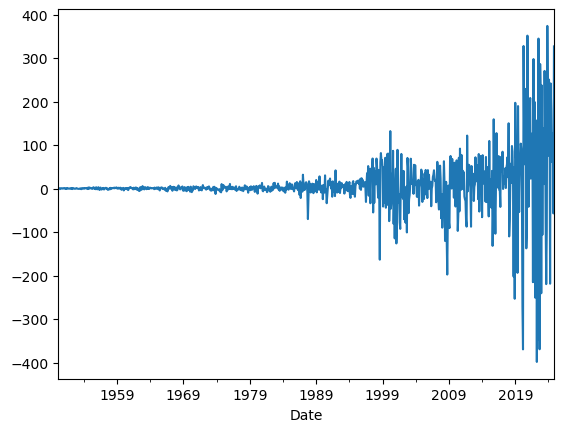

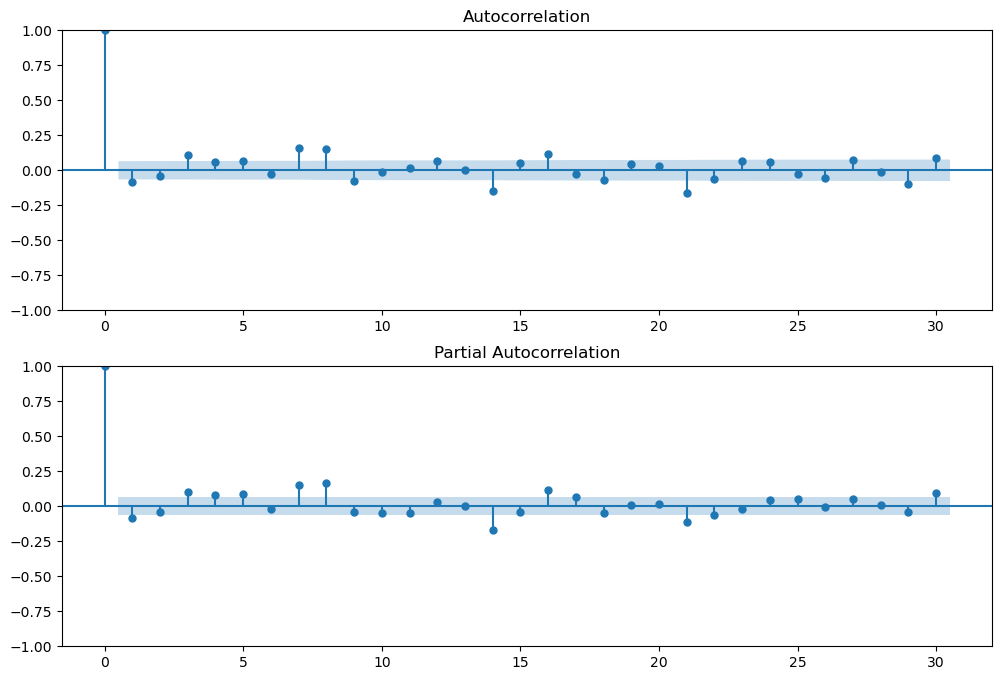

In [68]:
True_price_diff.plot()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(True_price_diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(True_price_diff, lags=30, ax=ax2, method='ywm')

### Now that we have seen that there is autocorrelation in the white noise, we apply a ARMA model on the TS

In [69]:
#===========================================================================
# estimate ARMA 
#===========================================================================
ar_order = [0, 1, 2, 3, 4, 5]
d_order = [0]
ma_order = [0, 1, 2, 3, 4]
arma_res = [list(orders) for orders in product(ar_order, d_order, ma_order)]
#     pprint.pprint(arma_res)

# sm.tsa.arima.model.ARIMA
for order in arma_res:
    print('fitting: ar:{} -d:{} - ma:{}'.format(*order)) 
    try:
        arma_model = sm.tsa.arima.ARIMA(True_price_diff, order=order).fit()
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])
    
res = pd.DataFrame(arma_res, columns = ['ar_order', 'd_order', 'ma_order', 'aic', 'bic'])
print('criterion\n', res)

fitting: ar:0 -d:0 - ma:0
fitting: ar:0 -d:0 - ma:1
fitting: ar:0 -d:0 - ma:2
fitting: ar:0 -d:0 - ma:3
fitting: ar:0 -d:0 - ma:4
fitting: ar:1 -d:0 - ma:0
fitting: ar:1 -d:0 - ma:1
fitting: ar:1 -d:0 - ma:2
fitting: ar:1 -d:0 - ma:3
fitting: ar:1 -d:0 - ma:4
fitting: ar:2 -d:0 - ma:0
fitting: ar:2 -d:0 - ma:1


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:2 -d:0 - ma:2
fitting: ar:2 -d:0 - ma:3
fitting: ar:2 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:3 -d:0 - ma:0
fitting: ar:3 -d:0 - ma:1
fitting: ar:3 -d:0 - ma:2


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


fitting: ar:3 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


fitting: ar:3 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:0
fitting: ar:4 -d:0 - ma:1
fitting: ar:4 -d:0 - ma:2


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packa

fitting: ar:4 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:4 -d:0 - ma:4


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:0
fitting: ar:5 -d:0 - ma:1
fitting: ar:5 -d:0 - ma:2
fitting: ar:5 -d:0 - ma:3


c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


fitting: ar:5 -d:0 - ma:4
criterion
     ar_order  d_order  ma_order        aic        bic
0          0        0         0  10.002979  10.012579
1          0        0         1   9.998455  10.012855
2          0        0         2  10.000230  10.019431
3          0        0         3   9.988172  10.012173
4          0        0         4   9.989449  10.018250
5          1        0         0   9.998863  10.013263
6          1        0         1  10.000396  10.019597
7          1        0         2   9.981856  10.005857
8          1        0         3   9.967564   9.996365
9          1        0         4   9.969468  10.003069
10         2        0         0   9.999075  10.018275
11         2        0         1   9.996041  10.020042
12         2        0         2   9.968600   9.997401
13         2        0         3   9.968384  10.001986
14         2        0         4   9.967232  10.005633
15         3        0         0   9.990926  10.014926
16         3        0         1   9.971609  1

c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
# best is ARMA(3, 4)
res = sm.tsa.arima.ARIMA(True_price_diff, order=(3,0,4)).fit()
res
print(res.summary())
res.aic

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  898
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -4957.381
Date:                Wed, 01 Jan 2025   AIC                           9932.763
Time:                        02:37:10   BIC                           9975.964
Sample:                    02-01-1950   HQIC                          9949.268
                         - 11-01-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.7512     71.555      0.094      0.925    -133.495     146.997
ar.L1          0.9897      0.009    108.412      0.000       0.972       1.008
ar.L2         -0.9604      0.010    -97.766      0.0

c:\Users\graci\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9932.762966552897

### We then run a ARCH test on the residuals to make sure that we have homoskedacity - we don't btw

In [71]:
residus = res.resid

In [72]:
#===========================================================================
# ARCH tests 
#===========================================================================

n_autocor = 5
sm.stats.diagnostic.acorr_ljungbox(residus**2, lags=[n_autocor])
#We have heteroskedacity

,lb_stat,lb_pvalue
5,735.103968,1.259838e-156


# We run a GARCH model on the residuals

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6207.94484444074
Iteration:      2,   Func. Count:     12,   Neg. LLF: 6455.436482509011
Iteration:      3,   Func. Count:     20,   Neg. LLF: 4011.848561598202
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3990.726819374558
Iteration:      5,   Func. Count:     30,   Neg. LLF: 3979.1596378966797
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3940.6414822295033
Iteration:      7,   Func. Count:     40,   Neg. LLF: 4068.20913130059
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3912.276247406519
Iteration:      9,   Func. Count:     51,   Neg. LLF: 4968.098748938582
Iteration:     10,   Func. Count:     59,   Neg. LLF: 4802.175849725851
Iteration:     11,   Func. Count:     65,   Neg. LLF: 3757.3012273486875
Iteration:     12,   Func. Count:     71,   Neg. LLF: 3683.1991030999598
Iteration:     13,   Func. Count:     76,   Neg. LLF: 3657.4669700063714
Iteration:     14,   Func. Count:     81,   Neg. LLF: 3649.64

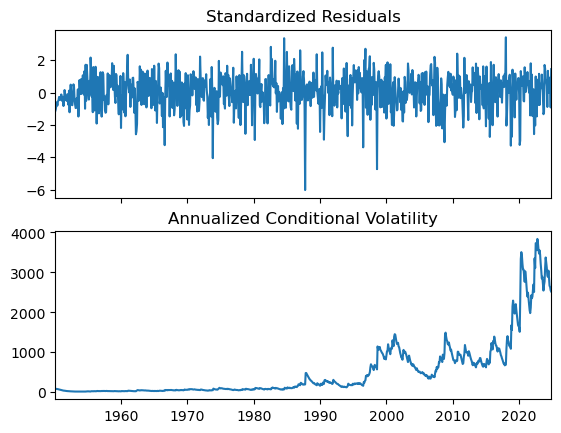

In [73]:
garch_res = arch_model(residus, p=1, o=0, q=1, dist='normal').fit()
print(garch_res.summary())
fig = garch_res.plot(annualize='D')

# Forecast

In [74]:
# Fit HMM with 6 regimes
log_returns = log_returns.values.reshape(-1, 1)

hmm_model = GaussianHMM(n_components=6, covariance_type="diag", init_params="c")
hmm_model.fit(log_returns)

hidden_states = hmm_model.decode(log_returns)[1]

c:\Users\graci\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [75]:
# Rescale the data
log_returns_rescaled = log_returns * 100

regimes = {}
garch_models = {}

# Loop through each hidden state (regime)
for i in range(hmm_model.n_components):  # Replace `hmm.n_components` with `hmm_model.n_components` if needed
    # Extract regime data
    regimes[i] = log_returns_rescaled[hidden_states == i]
    
    if len(regimes[i]) > 0:  # Check if the regime has data
        print(f"Fitting GARCH(1,1) for Regime {i}...")
        garch_models[i] = arch_model(regimes[i], vol='Garch', p=1, q=1).fit(disp="off")
        print(f"\nRegime {i} GARCH Summary:")
        print(garch_models[i].summary())
    else:
        print(f"\nRegime {i} has no data.")

Fitting GARCH(1,1) for Regime 0...

Regime 0 GARCH Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -499.103
Distribution:                  Normal   AIC:                           1006.21
Method:            Maximum Likelihood   BIC:                           1019.67
                                        No. Observations:                  214
Date:                Wed, Jan 01 2025   Df Residuals:                      213
Time:                        02:37:13   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu        

c:\Users\graci\anaconda3\Lib\site-packages\arch\univariate\volatility.py:1215: RuntimeWarning: invalid value encountered in scalar divide
  scale = np.mean(resids**2) / (target ** (2.0 / power))
c:\Users\graci\anaconda3\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in log
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\graci\anaconda3\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\graci\anaconda3\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: divide by zero encountered in divide
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\graci\anaconda3\Lib\site-packages\arch\univariate\distribution.py:449: RuntimeWarning: invalid value encountered in add
  lls = -0.5 * (log(2 * pi) + log(sigma2) + resids ** 2.0 / sigma2)
c:\Users\

ZeroDivisionError: float division by zero

In [ ]:
# Forecast volatility for each regime

#start = dt.datetime(2006,11,1)
# end = dt.datetime(2016,11,1, start=split_date, reindex=True)
split_date = dt.datetime(2007,7,2)  
#I estimate the model from the 1st obs to the split date

def forecast_volatility(garch_models):
    forecasts = []
    
    for i, garch_model in enumerate(garch_models, 1):
        forecast = garch_model.forecast(horizon=1)
        forecast_value = forecast.variance.iloc[-1, 0]
        forecasts.append(forecast_value)
        print(f"Regime {i} Volatility Forecast: {forecast_value}")
    
    return forecasts

garch_models_list = [garch_models[i] for i in range(hmm_model.n_components)]
forecast_volatility(garch_models_list)

#garch_models = [garch_models[0], garch_models[1], garch_models[2], garch_models[3], garch_models[4], garch_models[5]]
#forecast_volatility(garch_models)

Regime 1 Volatility Forecast: 7.276259683657763
Regime 2 Volatility Forecast: 10.481125674327131
Regime 3 Volatility Forecast: 13.086390645899835
Regime 4 Volatility Forecast: 6.654264580745384
Regime 5 Volatility Forecast: 46.81378927829157
Regime 6 Volatility Forecast: 15.17758440337542


[7.276259683657763,
 10.481125674327131,
 13.086390645899835,
 6.654264580745384,
 46.81378927829157,
 15.17758440337542]

In [94]:
# Predict regime probabilities for the next time step
next_probs = hmm_model.predict_proba(log_returns_rescaled.reshape(-1, 1))[-1]

regime_1_prob = next_probs[0]
regime_2_prob = next_probs[1]
regime_3_prob = next_probs[2]
regime_4_prob = next_probs[3]
regime_5_prob = next_probs[4]
regime_6_prob = next_probs[5]

forecasts = forecast_volatility(garch_models_list)

# Combine forecasts based on regime probabilities
combined_forecast = sum(next_probs[i] * forecasts[i] for i in range(len(forecasts)))

print(f"Combined Volatility Forecast: {combined_forecast}")

# Combine forecasts
# combined_forecast = regime_1_prob * forecast_1 + regime_2_prob * forecast_2 + regime_3_prob * forecast_3 + regime_4_prob * forecast_2 + regime_2_prob * forecast_2
# print(f"Combined Volatility Forecast: {combined_forecast}")


Combined Volatility Forecast: 0.0017567145617945008


In [96]:
# Simulate next price
current_price = monthly_with_dates['Close'].iloc[-1]
next_return = np.random.normal(0, np.sqrt(combined_forecast))
next_price = current_price * np.exp(next_return)

print(f"Predicted Next Price: {next_price}")


Predicted Next Price: 6201.519711290832
